# Regression
--------
Regression is a kind of supervised learning where we have a target variable or something we want to predict. The difference between regression and classification is that in regression, our target variable is numeric and continous.

## Predicting Numeric Values

A standard regression function to create a best-fit line for the data in data/ex0.txt

In [52]:
# Import
from numpy import *
import collections
import matplotlib.pyplot as plt

`LoadDataSet()` function opens a file with tab-delimited values and assumes the last value is the target

In [53]:
# Load data
def loadDataSet(filename):
    """
   load dataset into data-matrix and label-matrix
   
   Parameters
   ----------
   filename : String
       File path containing the data
       
   Returns
   -------
   dataLabel : collections
       a simple class which represents the data-matrix and label-matrix
   """    
    #use collections.namedtuple to construct a simple class to represent each data matrix
    data = collections.namedtuple('data',['dataMat','labelMat'])
    
    with open(filename) as file:
        numFeat = len(file.readline().split('\t')) - 1  # Assumes last value is the taget(-1)
        
    dataMat = []; labelMat = []
    with open(filename) as file:
        for line in file.readlines():
            lineArr = []
            curLine = line.strip().split('\t')
            [lineArr.append(float(curLine[i])) for i in range(numFeat)]
            dataMat.append(lineArr)
            labelMat.append(float(curLine[-1]))
    dataLabel = data(dataMat, labelMat) 
    return  dataLabel     

In [54]:
filename = '../data/ex0.txt'
data = loadDataSet(filename)

In [55]:
data.dataMat[0:2]

[[1.0, 0.067732], [1.0, 0.42781]]

In [56]:
data.labelMat[0:2]

[3.176513, 3.816464]

### Compute best-fit line
Assume our input data is in the matrix X, and our regression weights in the vector w. For a given piece of data $X_1$, our predicted value is given by $y_1= X^T_1w$

We have **Xs** and **ys**, but how can we find the **ws**? One way is to find the ws that minimize the error. We define error as the difference between predicted y and the actual y. Using just the error will allow positive and negative values to cancel out, so we use the squared error as:

$$\sum_{i=0}^m(y_i-x^T_iw)^2$$

Writing this in matrix notation, we have $(y-Xw)^T(y-Xw)$

If we take the derivative of this with respect to w, we'll get $X^T(y-Xw)$

We can set this to zero and solve for **w** to get the following final equation:

$$w= (X^TX)^{-1}X^Ty$$


**NB**: The final equation has $X^TX^{-1}$, which is a matrix inverse. Hence we have to first check for matrix inverse existance before using it or we may have an error.

In [57]:
def standRegres(xArr, yArr):
    """
   Fine weight given the data  and the predicted value
   
   Parameters
   ----------
   xArr : List
       Our data
       
    yArr: List
        our predicted value
       
   Returns
   -------
   ws : float
       regression weight
   """
    # convert arrays to matrices
    xMat = mat(xArr); yMat = mat(yArr).T
    # compute xTx and check if determinate is zero
    xTx = xMat.T*xMat
    if linalg.det(xTx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    ws = xTx.I * (xMat.T * yMat)
    return ws

In [58]:
ws = standRegres(data.dataMat, data.labelMat)
ws

matrix([[ 3.00774324],
        [ 1.69532264]])

In [59]:
xMat = mat(data.dataMat)
yMat = mat(data.labelMat)
# Our predicted value yHat using the weights (ws)
yHat = xMat*ws

### Plot and show best-fit line

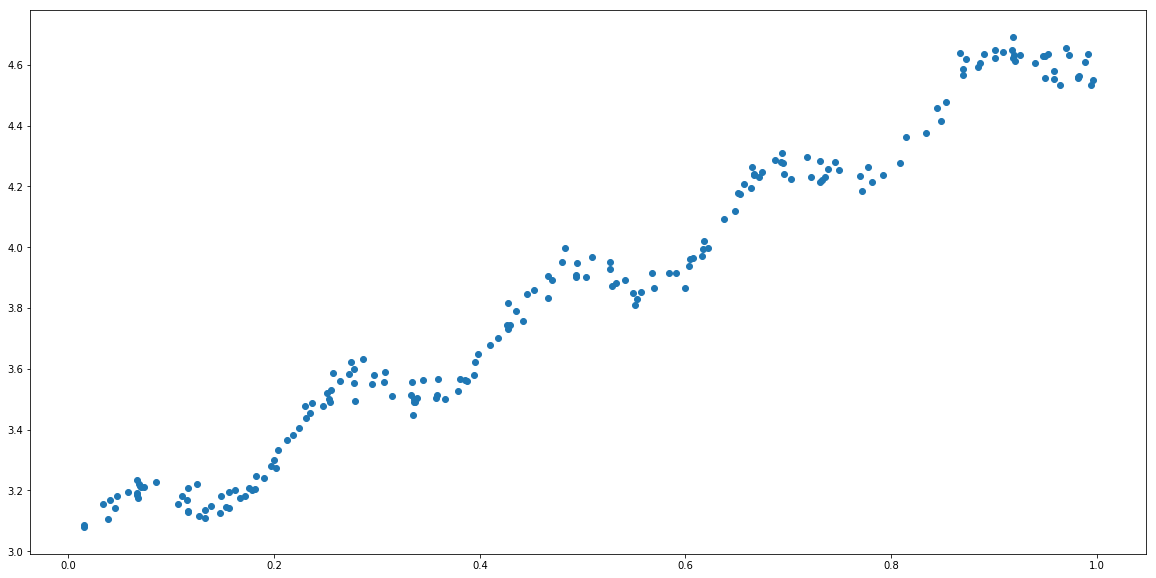

In [60]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])
plt.show()

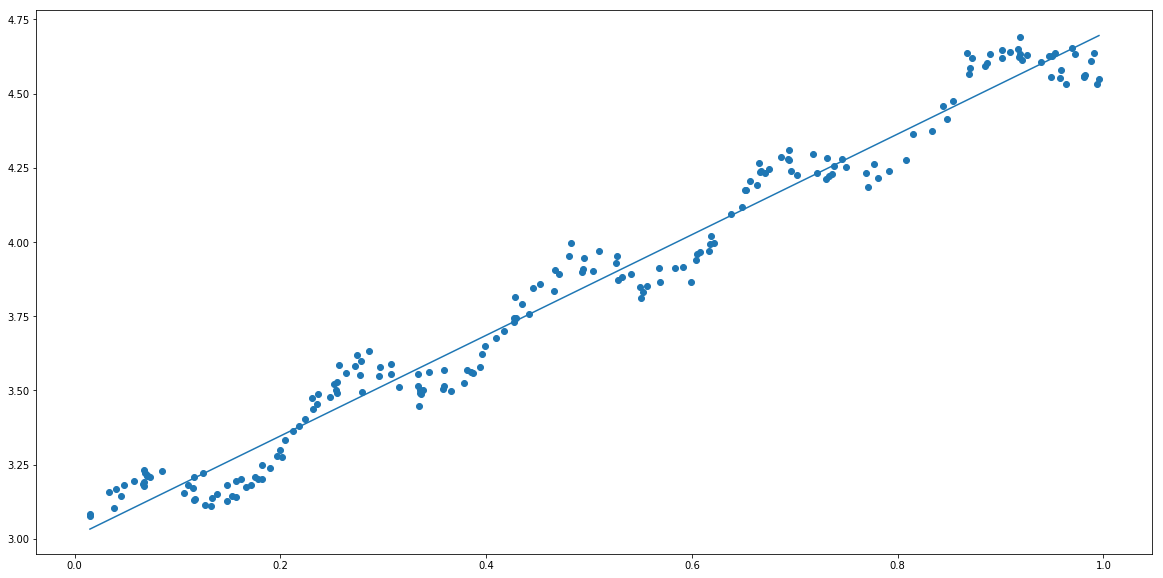

In [61]:
xCopy = xMat.copy()
xCopy.sort(0)

yHat = xCopy*ws

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])
ax.plot(xCopy[:,1],yHat)
plt.show()

### Check Correlation coefficient
To calculate how well the predicted value, yHat, matches our actual data, y, we check the correlation between the two series

In [62]:
# Get predicted value(unsorted)
# Transpose yHat so we have both vectors as row vectors
yHat = xMat*ws
corrcoef(yHat.T, yMat)

array([[ 1.        ,  0.98647356],
       [ 0.98647356,  1.        ]])

From the above results, element in the digonal are **1.0** becuase the correlation between yMat and yMat is perfect. However, we have a correlation of **0.98** between yHat and yMat. Hence our model has done well in its prediction

## Locally Weighted Linear Regression (LWLR)
Linear regression has one problem, is that it tends to underfit the data. It gives us the lowest mean-squared error for unbaised estimators. Hence with underfitting, we aren't getting the best predictions.

One way to reduce the mean-squared error is a technique known as LWLR. With LWLR, we give a weight to data points near our data point of interest; then we compute a least-square regression. The fomula now becomes:

$$w=(X^TWX)^{-1}X^TWy$$

**W** here is a matrix that's used to weight the data points.
LWLR uses a kernel similar to the one in SVM to weight nearby points more heavily than other points. The most common kernel to use is a **Gaussian**. This assigns a weight given by

$$w(i,i)=\exp( \frac{|x^{(i)}-x|}{-2k^2})$$

- From the formula above, the closer the data point **x** is to the other points, the larget **w(i,i)** will be.
- We also see a constant **k** which is a user-defined constant that will determine how much to weight nearby points. This is the only parameter we have to worry about with LWLR

### Pros
- With a suitable **k** value, we can have a best-fit for our data free from overfitting and underfitting

### Cons
- It involve alot of computation. You must use the entire data to fine a single estimate

In [63]:
def lwlr(testPoint, xArr, yArr, k=0.1):
    """
    Generate an estimate for any point in the x space

    Parameters
    ----------
    testPoint: float
       point in the x space
    xArr : List
       Our data      
    yArr: List
        our predicted value
    k: float
        user-defined constant that determine how much to weight the point

    Returns
    -------
    ws : float
       regression weight
    """    
    xMat = mat(xArr); yMat = mat(yArr).T
    # Create diagonal matrix
    m = shape(xMat)[0]
    weights = mat(eye((m)))
    # Populate weights with exponentially decaying values
    for j in range(m):
        diffMat = testPoint - xMat[j,:]
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
        
    # find extimate for testpoint
    xTwx = xMat.T * (weights * xMat)
    if linalg.det(xTwx) == 0.0:
        print("This matrix is singular, cannot do inverse")
        return
    
    ws = xTwx.I * (xMat.T * (weights*yMat))
    return testPoint*ws

def lwlrTest(testArr, xArr, yArr, k=1.0):
    """
    Generate an estimate for any point in the x space

    Parameters
    ----------
    testPoint: float
       point in the x space
    xArr : List
       Our data      
    yArr: List
        our predicted value
    k: float
        user-defined constant that determine how much to weight the point

    Returns
    -------
    ws : float
       regression weight
    """ 
    # Get arbituary yHat to be of same length as test data
    m = shape(testArr)[0]
    yHat = zeros(m)
    # Replace each entry by its weight
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat
    

In [64]:
data.labelMat[0]

3.176513

In [65]:
lwlr(data.dataMat[0], data.dataMat, data.labelMat, 1.0)

matrix([[ 3.12204471]])

In [66]:
lwlr(data.dataMat[0], data.dataMat, data.labelMat, 0.001)

matrix([[ 3.20175729]])

In [67]:
# find extimate yHat for all data points. Here best-fit is obtained with k=0.01
# k=0.003 will cause overfitting
# k=1.0 is same as normal linear Regression
k = 0.01
yHat = lwlrTest(data.dataMat, data.dataMat, data.labelMat, k)

In [68]:
# Plot needs the data to be sorted. Here, we sort xArr
"""
xMat = mat(data.dataMat)
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]
"""
xSort = xMat.copy()
xSort.sort(0)


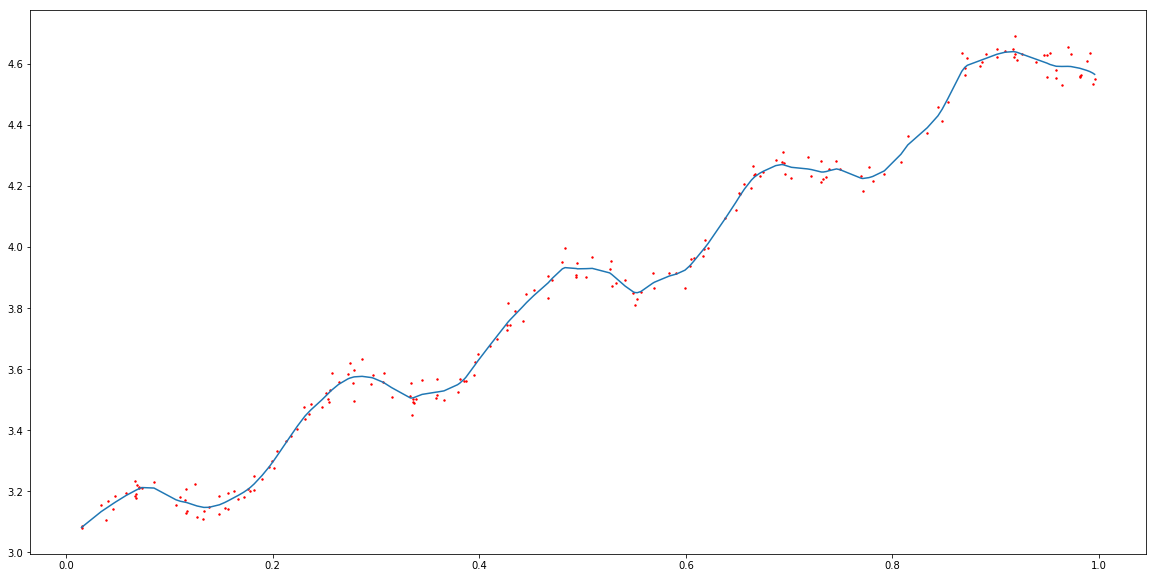

In [69]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(xSort[:,1], yHat[srtInd])
ax.scatter(xMat[:,1].flatten().A[0], mat(data.labelMat).T.flatten().A[0], s=2, c='red')
plt.show()